In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from mpl_toolkits.axes_grid1 import ImageGrid
import itertools 
import re
import os
from sklearn.model_selection import train_test_split 

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import img_to_array, ImageDataGenerator
from keras.preprocessing.image import load_img
from keras.applications.inception_v3 import preprocess_input, InceptionV3
from keras.regularizers import l2
from keras.callbacks import EarlyStopping

from PIL import Image
from PIL import ImageFilter

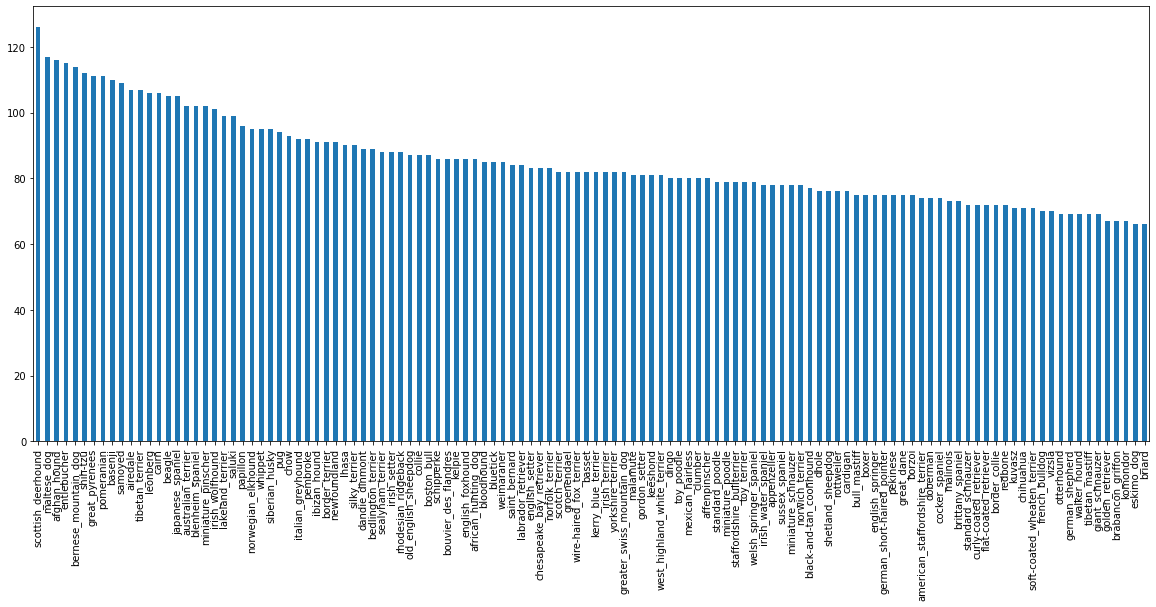

In [2]:
label = pd.read_csv('labels.csv', dtype=str)

plt.figure(figsize=(20, 8))
label['breed'].value_counts().plot(kind='bar')
plt.show()

In [3]:
def append_extention(fn):
    return fn+".jpg"
label["id"] = label["id"].apply(append_extention)

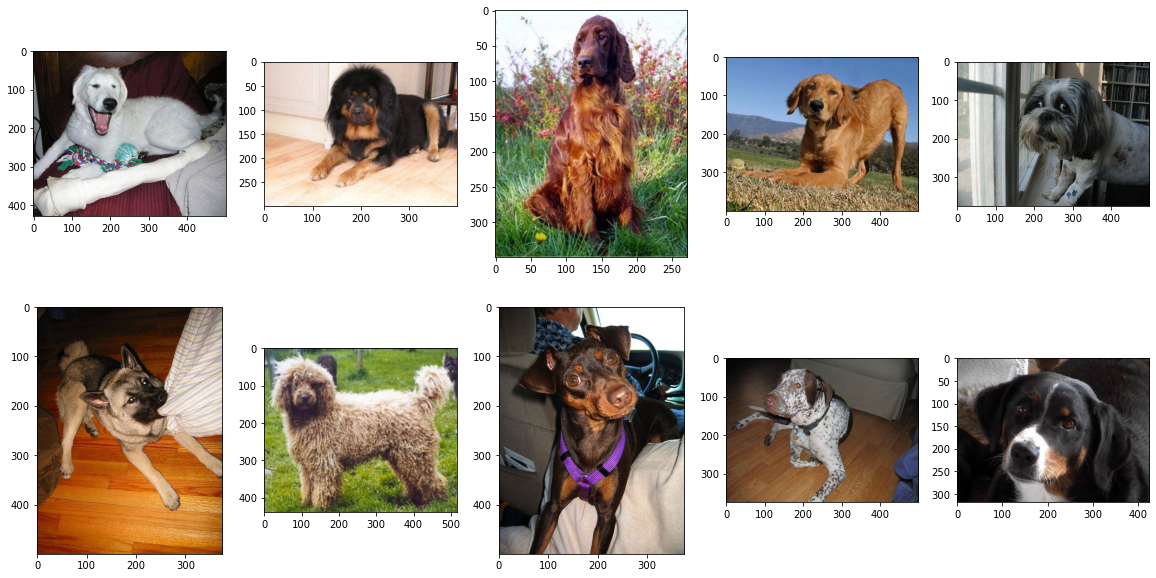

In [6]:
src_path = 'train'
sub_class = os.listdir(src_path)

plt.figure(figsize=(20,10))
for i in range(len(sub_class[:10])):
    plt.subplot(2, 5, i+1)
    img = plt.imread(os.path.join(src_path,sub_class[i]))
    plt.imshow(img, cmap=plt.get_cmap('gray'))

In [7]:
train_datagen=ImageDataGenerator( rescale=1./255.,
                                  #rotation_range = 20,
                                  #brightness_range=[0.2,1.0],
                                  #width_shift_range = 0.2,
                                  #height_shift_range = 0.2,
                                  #shear_range = 0.2,
                                  #zoom_range = [0.7,1],
                                  horizontal_flip = True,
                                  #Setting validation split to 2% 
                                  validation_split=0.1 
                                  )

In [8]:
batch_size = 64
image_size=(224,224)
train_generator = train_datagen.flow_from_dataframe(
                                    dataframe=label,
                                    directory='train',
                                    x_col='id',
                                    y_col='breed',
                                    subset='training',
                                    batch_size=batch_size,
                                    seed=42,
                                    shuffle=True,
                                    class_mode='categorical',
                                    target_size=image_size,
                                    color_mode='rgb' 
)

Found 9200 validated image filenames belonging to 120 classes.


In [9]:
x,y = next(train_generator)

In [10]:
print(type(x))
print(x.shape)
print(y.shape)

<class 'numpy.ndarray'>
(64, 224, 224, 3)
(64, 120)


In [11]:
def show_grid(image_list, nrows, ncols, figsize=(20,20), showaxis='off'):
    if type(image_list) is not list:
        if(image_list.shape[-1]==1):
            image_list = [image_list[i,:,:,0] for i in range(image_list.shape[0])]
        elif(image_list.shape[-1]==3):
            image_list = [image_list[i,:,:,:] for i in range(image_list.shape[0])]
    fig = plt.figure(None, figsize,frameon=False)
    grid = ImageGrid(fig, 111, 
                     nrows_ncols=(nrows, ncols),  
                     axes_pad=0.3,
                     share_all=True,
                     )
    for i in range(nrows*ncols):
        ax = grid[i]
        ax.imshow(image_list[i],cmap='Greys_r')
        ax.axis('off')
        

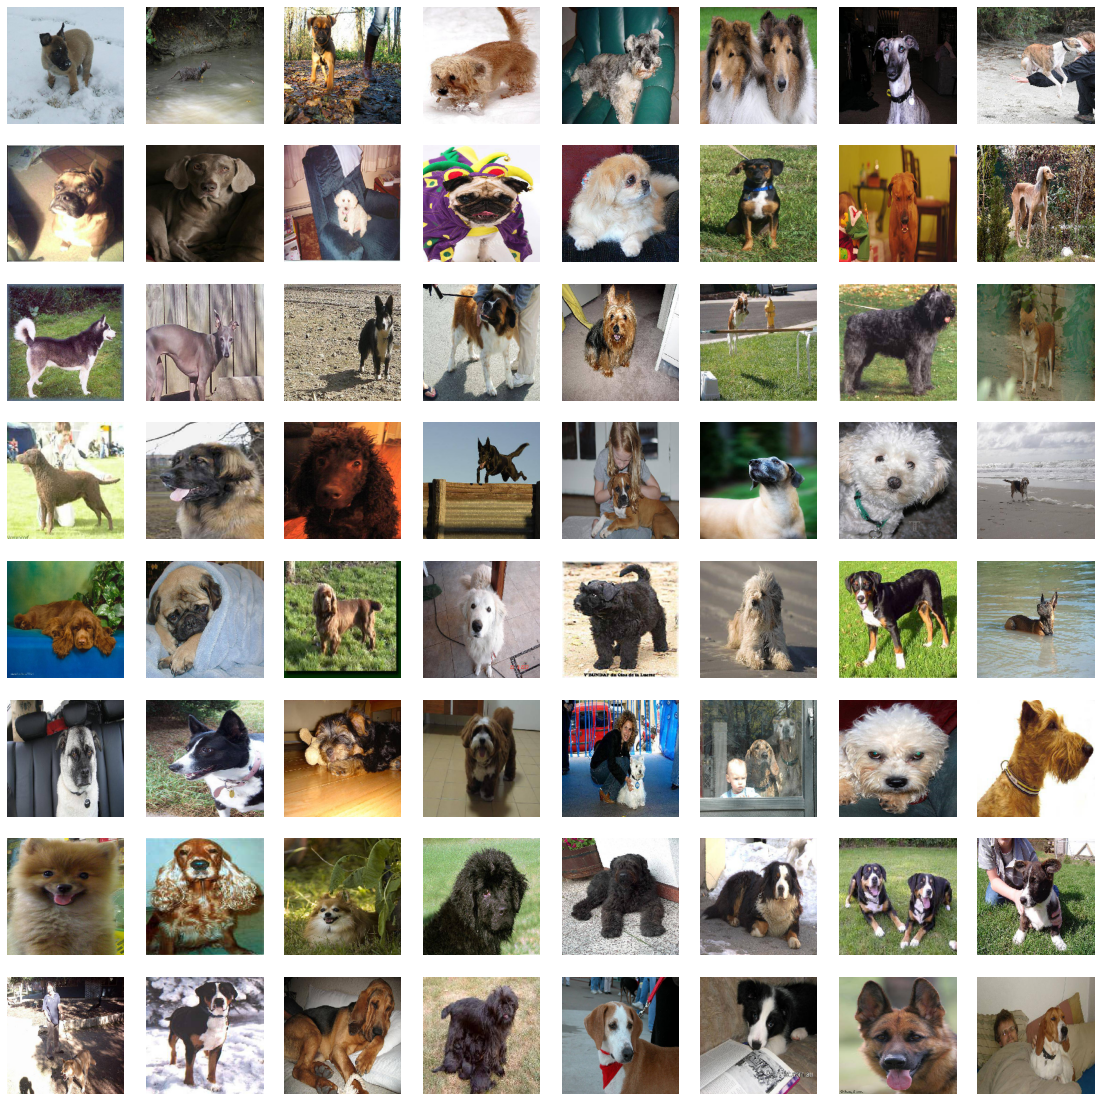

In [12]:
show_grid(x, 8, 8)

In [13]:
valid_generator = train_datagen.flow_from_dataframe(
                                            dataframe=label,
                                            directory='train',
                                            x_col='id',
                                            y_col='breed',
                                            subset='validation',
                                            batch_size=batch_size,
                                            seed=42,
                                            shuffle=True,
                                            class_mode='categorical',
                                            target_size=image_size,
                                            color_mode='rgb')

Found 1022 validated image filenames belonging to 120 classes.


In [26]:
shape = [224, 224, 3]
pretrained_model = InceptionV3(
        weights='imagenet',
        include_top=False ,
        input_shape=shape
    )
pretrained_model.trainable = False
    
model = Sequential([ 
        pretrained_model,   
        GlobalAveragePooling2D(),
        Dense(1024, activation='relu', kernel_regularizer=l2(1e-3)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(512, activation='relu', kernel_regularizer=l2(1e-3)),
        BatchNormalization(),
        Dropout(0.5),
        tf.keras.layers.Dense(120, activation='softmax')
    ])

In [27]:
sgd = tf.keras.optimizers.SGD(lr=1e-3, momentum=0.9)
adam = Adam(lr=0.00001, decay=1e-6)
model.compile(optimizer = adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 1024)              2098176   
                                                                 
 batch_normalization_284 (Ba  (None, 1024)             4096      
 tchNormalization)                                               
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 512)              

In [29]:
checkimprovement = EarlyStopping(patience=5, min_delta=0.001, restore_best_weights=True)

In [30]:
step_size_train = train_generator.n//train_generator.batch_size
step_size_val = valid_generator.n//valid_generator.batch_size

history_inception = model.fit(train_generator,
                    steps_per_epoch=step_size_train,
                    validation_data=valid_generator,
                    validation_steps=step_size_val,
                    epochs=100,
                    callbacks=[checkimprovement])

Epoch 1/100
143/143 [==============================] - 131s 910ms/step - loss: 4.8138 - accuracy: 0.4244 - val_loss: 3.6195 - val_accuracy: 0.7135
Epoch 2/100
143/143 [==============================] - 129s 902ms/step - loss: 3.0989 - accuracy: 0.7354 - val_loss: 2.9578 - val_accuracy: 0.7573
Epoch 3/100
143/143 [==============================] - 129s 905ms/step - loss: 2.8568 - accuracy: 0.7808 - val_loss: 2.8595 - val_accuracy: 0.7604
Epoch 4/100
143/143 [==============================] - 129s 905ms/step - loss: 2.7350 - accuracy: 0.8017 - val_loss: 2.7883 - val_accuracy: 0.7865
Epoch 5/100
143/143 [==============================] - 129s 904ms/step - loss: 2.6540 - accuracy: 0.8151 - val_loss: 2.7900 - val_accuracy: 0.7906
Epoch 6/100
143/143 [==============================] - 130s 906ms/step - loss: 2.5801 - accuracy: 0.8282 - val_loss: 2.7913 - val_accuracy: 0.7698
Epoch 7/100
143/143 [==============================] - 129s 901ms/step - loss: 2.5193 - accuracy: 0.8379 - val_loss: 2

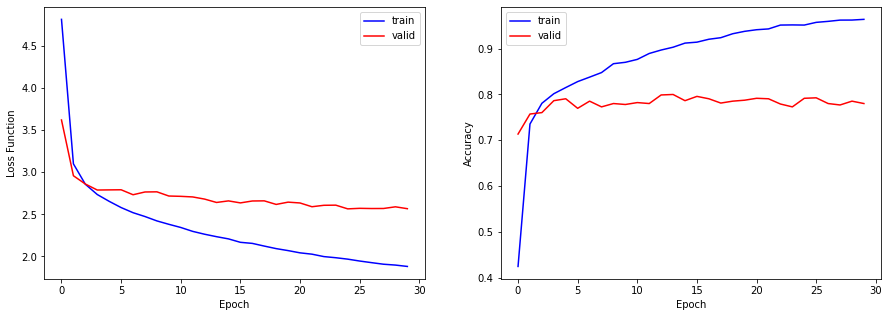

In [31]:
history(history_inception)

In [33]:
model.evaluate(valid_generator, batch_size=32)

16/16 [==============================] - 13s 811ms/step - loss: 2.5960 - accuracy: 0.7896


[2.5959882736206055, 0.7896282076835632]